In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
import h5py
import keras
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from hep_VQAE import utils as ut

from keras.initializers import Constant
from keras import backend as K
from keras.layers import PReLU

import tensorflow_addons as tfa

2022-09-01 10:18:30.426815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-01 10:18:30.426835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-09-01 10:18:31.885916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-01 10:18:31.885939: W tensorflow/

In [2]:
#f3 = h5py.File("../../data/quark-gluon/quark-gluon_train-set_n793900.hdf5","r")
#f2 = h5py.File("../../data/quark-gluon/quark-gluon_test-set_n10000.hdf5","r")
f = h5py.File("small_quark_gluon_candr","r")

In [3]:
x_train = f.get('X')
y_train = f.get('y')

#x_val = f2.get('X')
#y_val = f2.get('y')

#x_test = f2.get('X')
#y_test = f2.get('y')

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train[:], y_train[:], test_size=0.2, shuffle=True)

In [5]:
x_train_ones = x_train[y_train==1]
x_train_ones = x_train_ones.reshape(x_train_ones.shape + (1,))
x_train = x_train[y_train==0]
x_train = x_train.reshape(x_train.shape + (1,))

div1 = np.max(x_train, axis=(1,2)).reshape((x_train.shape[0],1,1,1))
div1[div1 == 0] = 1
x_train = x_train / div1
div2 = np.max(x_train_ones, axis=(1,2)).reshape((x_train_ones.shape[0],1,1,1))
div2[div2 == 0] = 1
x_train_ones = x_train_ones / div2

x_val_ones = x_val[y_val==1]
x_val_ones = x_val_ones.reshape(x_val_ones.shape + (1,))
x_val = x_val[y_val==0]
x_val = x_val.reshape(x_val.shape + (1,))

div1 = np.max(x_val, axis=(1,2)).reshape((x_val.shape[0],1,1,1))
div1[div1 == 0] = 1
x_val = x_val / div1
div2 = np.max(x_val_ones, axis=(1,2)).reshape((x_val_ones.shape[0],1,1,1))
div2[div2 == 0] = 1
x_val_ones = x_val_ones / div2


x_test = x_val
x_test_ones = x_val_ones

In [6]:
class Convolutional_Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Convolutional_Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(40, 40, 1)),
          layers.Conv2D(10, kernel_size=4, strides=1, padding='same'),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.Conv2D(10, kernel_size=4, strides=1, padding='same'),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.AveragePooling2D(pool_size=2),
          layers.Conv2D(5, kernel_size=4, strides=1, padding='same'),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.Conv2D(5, kernel_size=4, strides=1, padding='same'),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.Flatten(),
          layers.Dense(400),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.Dense(100),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.Dense(latent_dim, activation='sigmoid')])

        self.decoder = tf.keras.Sequential([
          layers.Dense(100),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.Dense(400),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.Reshape((20, 20, 1)),
          layers.Conv2D(5, kernel_size=4, strides=1, padding='same'),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.Conv2D(5, kernel_size=4, strides=1, padding='same'),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.UpSampling2D(size=2),
          layers.Conv2D(10, kernel_size=4, strides=1, padding='same'),
          PReLU(alpha_initializer=Constant(value=0.25)),
          layers.Conv2D(1, kernel_size=4, strides=1, activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
model = Convolutional_Autoencoder(28)

In [8]:
model.build(input_shape=(1,40,40,1))

In [9]:
model.summary()

Model: "convolutional__autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28)                882818    
                                                                 
 sequential_1 (Sequential)   (1, 40, 40, 1)            65261     
                                                                 
Total params: 948,079
Trainable params: 948,079
Non-trainable params: 0
_________________________________________________________________


In [10]:
learning_rate = 0.0001
weight_decay = 0.0001
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

In [11]:
#model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.05))
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [12]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-5)
hist = model.fit(x_train_ones,x_train_ones,epochs=120, batch_size=128, validation_data=(x_val_ones,x_val_ones),callbacks=[es])

Epoch 1/120


2022-09-01 10:18:33.153539: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 356697600 exceeds 10% of free system memory.
2022-09-01 10:18:33.364134: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 356697600 exceeds 10% of free system memory.


436/436 [==============================] - 115s 262ms/step - loss: 0.2207 - val_loss: 0.0166
Epoch 2/120
436/436 [==============================] - 108s 248ms/step - loss: 0.0145 - val_loss: 0.0137
Epoch 3/120
436/436 [==============================] - 112s 258ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 4/120
436/436 [==============================] - 112s 257ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 5/120
436/436 [==============================] - 123s 283ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 6/120
436/436 [==============================] - 132s 302ms/step - loss: 0.0123 - val_loss: 0.0123
Epoch 7/120
436/436 [==============================] - 132s 304ms/step - loss: 0.0120 - val_loss: 0.0119
Epoch 8/120
436/436 [==============================] - 119s 274ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 9/120
436/436 [==============================] - 117s 269ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 10/120
436/436 [==============================] - 117s 268ms/

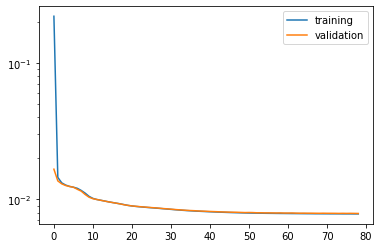

In [13]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.yscale('log')
plt.legend()

Collapse_metric: 0.846
Average EMD: 20.0
ssim: 0.882
MAE: 0.0038
normalized MAE: 0.000762


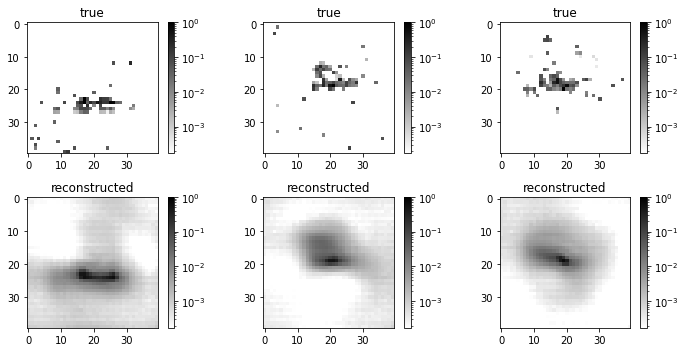

In [14]:
recon = model.predict(x_test[:500])

ut.eval_recon(x_test[:500], recon, lognorm=True)

Collapse_metric: 0.884
Average EMD: 12.2
ssim: 0.935
MAE: 0.00229
normalized MAE: 0.000642


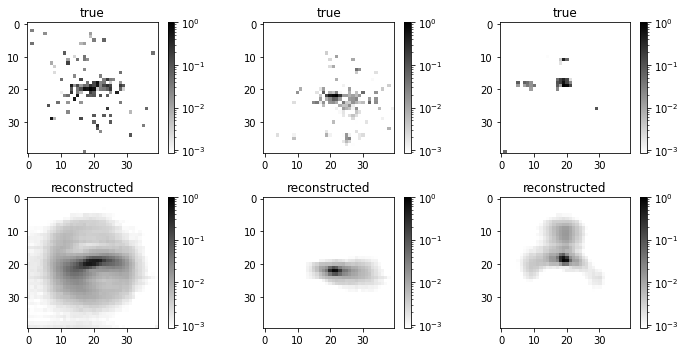

In [15]:
recon = model.predict(x_test_ones[:500])

ut.eval_recon(x_test_ones[:500], recon, lognorm=True)

Median background: 0.00633
Median signal: 0.0108
Maximum accuracy: 0.648
AUC: 0.7011


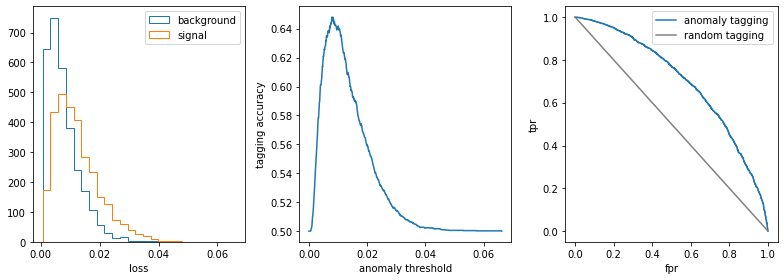

In [16]:
recon = model.predict(x_test[:3000])
recon_1 = model.predict(x_test_ones[:3000])

ut.eval_tagging(x_test_ones[:3000], recon_1, x_test[:3000], recon)